In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Load

In [2]:
df = pd.read_csv('../input/used-cars-database/autos.csv',encoding='Latin-1')

In [3]:
df.head(3)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


*Only Ford vehicles will be included in the next steps

In [4]:
df_ford = df.query('brand == "ford" ')

# Exploratory Data Analysis

In [5]:
df_ford.head(3)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
8,2016-04-04 23:42:13,Ford_C___Max_Titanium_1_0_L_EcoBoost,privat,Angebot,14500,control,bus,2014,manuell,125,c_max,30000,8,benzin,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
15,2016-03-11 21:39:15,KA_Lufthansa_Edition_450_VB,privat,Angebot,450,test,kleinwagen,1910,NaN,0,ka,5000,0,benzin,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
18,2016-03-23 15:48:05,Ford_C_MAX_2.0_TDCi_DPF_Titanium,privat,Angebot,7550,test,bus,2007,manuell,136,c_max,150000,6,diesel,ford,nein,2016-03-23 00:00:00,0,88361,2016-04-05 18:45:11


In [6]:
df_ford.shape

(25573, 20)

In [7]:
df_ford.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25573 entries, 8 to 371429
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dateCrawled          25573 non-null  object
 1   name                 25573 non-null  object
 2   seller               25573 non-null  object
 3   offerType            25573 non-null  object
 4   price                25573 non-null  int64 
 5   abtest               25573 non-null  object
 6   vehicleType          22753 non-null  object
 7   yearOfRegistration   25573 non-null  int64 
 8   gearbox              24151 non-null  object
 9   powerPS              25573 non-null  int64 
 10  model                24554 non-null  object
 11  kilometer            25573 non-null  int64 
 12  monthOfRegistration  25573 non-null  int64 
 13  fuelType             23024 non-null  object
 14  brand                25573 non-null  object
 15  notRepairedDamage    20157 non-null  object
 16  dat

In [8]:
df_ford.describe().T

,count,mean,std,min,25%,50%,75%,max
price,25573.0,8462.054706,633944.783555,0.0,750.0,1699.0,4200.0,99999999.0
yearOfRegistration,25573.0,2003.968639,55.880831,1000.0,2000.0,2003.0,2008.0,9000.0
powerPS,25573.0,95.680327,183.133148,0.0,60.0,90.0,120.0,15001.0
kilometer,25573.0,123839.987487,39811.613136,5000.0,100000.0,150000.0,150000.0,150000.0
monthOfRegistration,25573.0,5.545654,3.718698,0.0,3.0,5.0,9.0,12.0
nrOfPictures,25573.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postalCode,25573.0,49487.621319,24677.085829,1067.0,30823.0,49497.0,66740.0,99998.0


## NaN Values

In [9]:
nan_cols = df_ford.isna().sum()

In [10]:
nan_cols[nan_cols>0]

vehicleType          2820
gearbox              1422
model                1019
fuelType             2549
notRepairedDamage    5416
dtype: int64

* From the described DataFrame, max price seems a bit expensive
* I would not place Ford in the category of a premium automaker
* Regular used car prices higher than 60.000€ seem to be off (oldtimer excluded from this hypothesis)
* Cars that are too cheap are also excluded, often not representative

In [11]:

filt60k = df_ford['price']>60000
filt1_under_500 = (df_ford['price']>1) & (df_ford['price']<500)

print(f"Cars over 60.000€: {len(df_ford[filt60k])}")
print(f"Cars under 500€: {len(df_ford[filt1_under_500])}")

Cars over 60.000€: 14
Cars under 500€: 3273


In [12]:
df_ford = df_ford.query('price < 60000 & price > 499')

In [13]:
df_ford.shape

(21492, 20)

## Distribution Price over Years

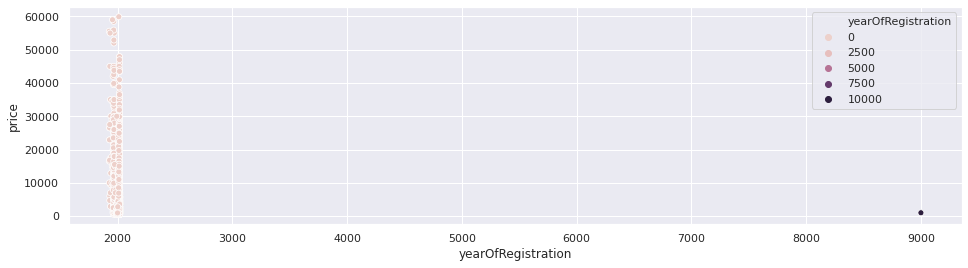

In [14]:
plt.figure(figsize=(16,4))
sns.scatterplot(x='yearOfRegistration', y='price', data=df_ford, hue='yearOfRegistration')
plt.show()

Something is wrong with the dates, let's take a closer look:
* Create a Date range from 1900 until current year
* Then check the dates that are out of our range of our somehow realistic values

In [15]:
min_date=1900
now = datetime.datetime.now()
max_date_current_year = now.year

In [16]:
df_ford.query("yearOfRegistration < @min_date | yearOfRegistration > @max_date_current_year")

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
47846,2016-03-23 17:40:00,Ford_Fiesta_ausgebrannt,privat,Angebot,999,control,NaN,9000,NaN,0,fiesta,10000,0,NaN,ford,ja,2016-03-23 00:00:00,0,50733,2016-04-05 21:44:28


* Filter out the unrealistic/wrong values
* Then check scatterplot again

In [17]:
df_ford = df_ford.query("yearOfRegistration > @min_date & yearOfRegistration <= @max_date_current_year")

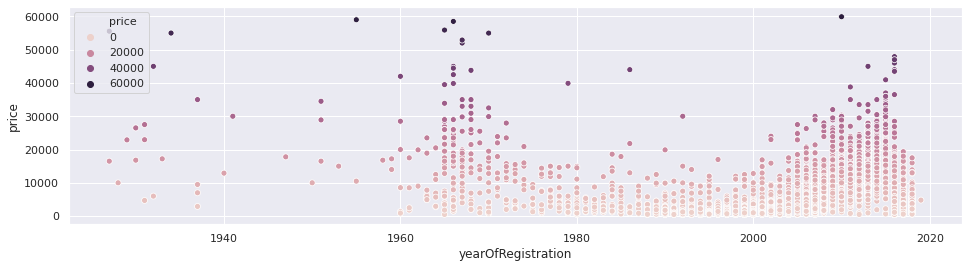

In [18]:
plt.figure(figsize=(16,4))
sns.scatterplot(x='yearOfRegistration', y='price', data=df_ford, hue='price')
plt.show()

* We don't have too many datapoints below 1970
* Adjust dataset: Remove years lower than 1970

In [19]:
years_over_seventy = (df_ford['yearOfRegistration'] > 1969)
df_ford = df_ford.loc[years_over_seventy]

## Distribution of years

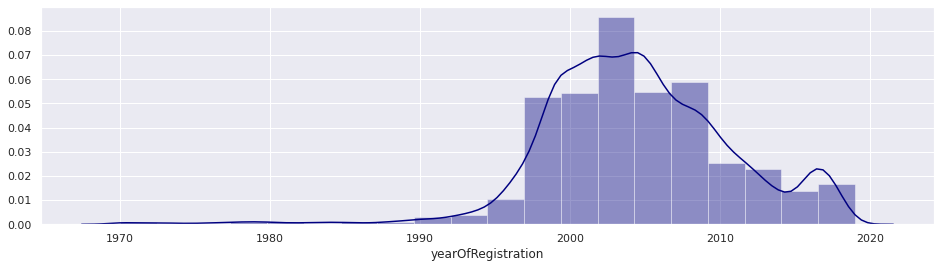

In [20]:
f = plt.figure(figsize=(16,4))
sns.distplot(df_ford['yearOfRegistration'], kde=True, bins=20, color='navy')
plt.show()

* Most cars in the range 2000-2010

## Distribution of kilometers

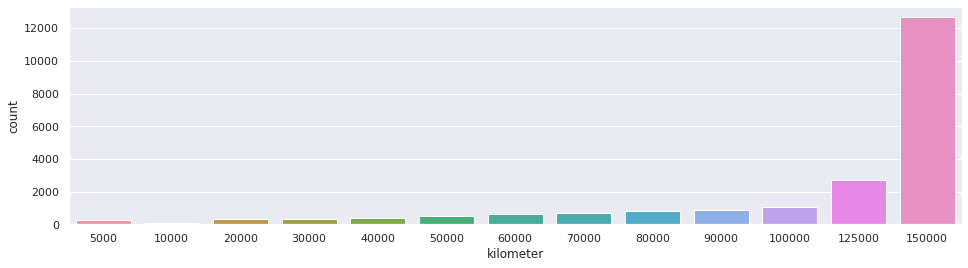

In [21]:
f = plt.figure(figsize=(16,4))
sns.countplot(x=df_ford['kilometer'], data=df_ford)
plt.show()

* Most cars have more than 100.000 km
* Let's categorize them and plot it

In [22]:
df_km_check = df_ford.copy()
df_km_check['km_category'] = df_km_check['kilometer'].apply(lambda x: 'Less or equal 100.000 km' if x<=100000 else 'Greater 100.000 km')

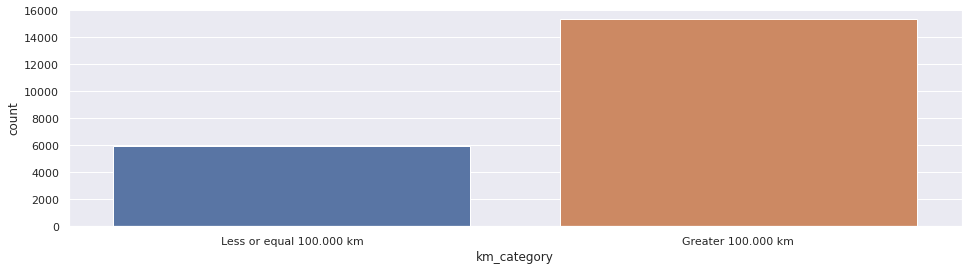

In [23]:
plt.figure(figsize=(16,4))
sns.countplot(df_km_check['km_category'])
plt.show()

## Price over km

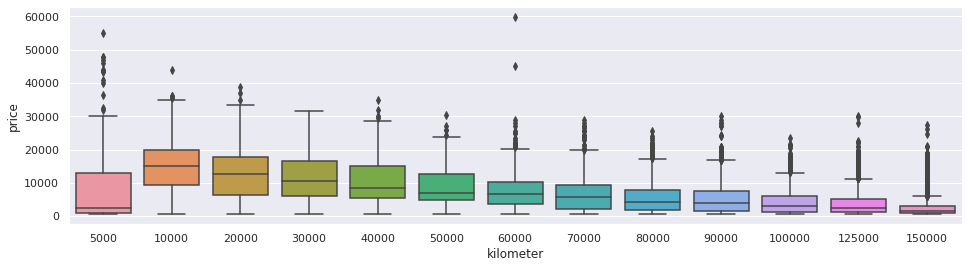

In [24]:
f = plt.figure(figsize=(16,4))
sns.boxplot(x='kilometer', y='price', data=df_ford)
plt.show()

* The assumption that cars with less kilometer have higher prices tend to be also true for this dataset
* Depends on the model of the car, Ford ka with less km could have smaller price than Mustang with significant more km

## Check vehicle type: Number of cars and price range

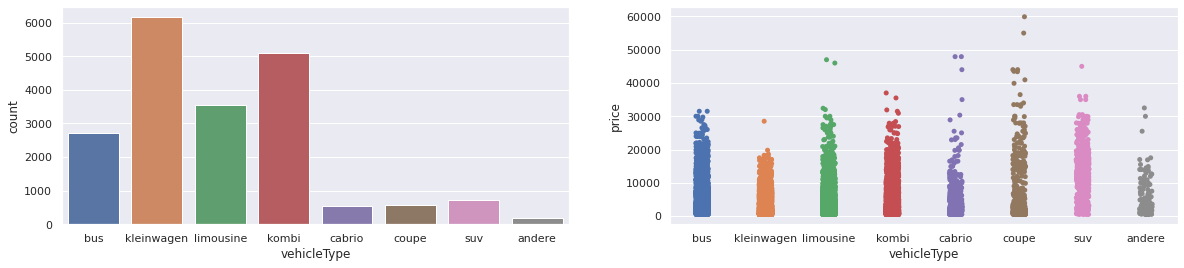

In [25]:
f = plt.figure(figsize=(20,4))
f.add_subplot(1,2,1)
sns.countplot(df_ford['vehicleType'])
f.add_subplot(1,2,2)
sns.stripplot(y='price', x='vehicleType', data=df_ford)
plt.show()

* There are some vehicle types that occur more often than others
* Adjust data set, remove category "andere" (others) from dataset
* Also remove cars without vehicle type

In [26]:
vehicle_filt = ((df_ford['vehicleType'].notna()) & (~df_ford['vehicleType'].str.contains('andere', na=True)))
df_ford = df_ford.loc[vehicle_filt]

## Check PS and PS <= 460 (Max regular Mustang PS)

* Ford Germanys current most powerful Mustang version has 460 ps
* I did not dive to deep in the evolution of Mustangs and their ps so I take 460 as the limit
* One one side I will check the overall situation of the data set and on the other when I limit it to 460 ps cars

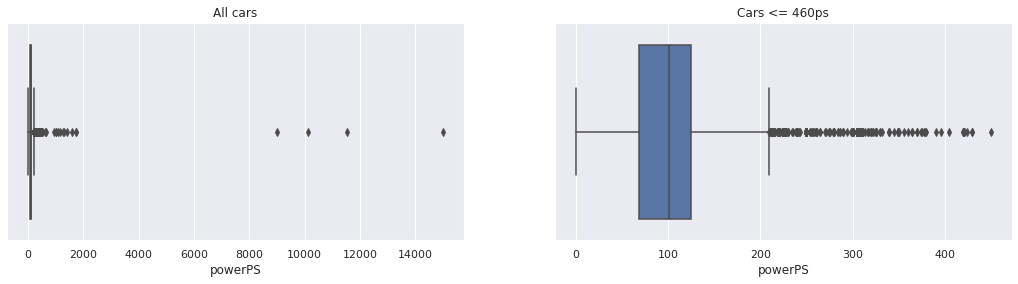

In [27]:
f = plt.figure(figsize=(18, 4))
f.add_subplot(1,2,1)
sns.boxplot(df_ford['powerPS'])
plt.title('All cars')
f.add_subplot(1,2,2)
sns.boxplot(df_ford.query("powerPS <= 460")['powerPS'])
plt.title('Cars <= 460ps')
plt.show()

* Here a quick look at cars between 461 ps and 800 ps
* Let's check how many rows we will lose when we remove them

In [28]:
ps_filt = (df_ford['powerPS']>460) & (df_ford['powerPS']<=800)
df_ford.loc[ps_filt, ['model', 'powerPS', 'kilometer','price']]

,model,powerPS,kilometer,price
74941,mustang,650,5000,54990
82508,mustang,500,60000,22000
114785,andere,518,40000,23999
163868,mustang,525,10000,19500
164460,mustang,604,60000,59900
166225,mustang,500,40000,24900
367589,mustang,500,40000,24900
368075,focus,473,150000,20950


* We can also see that there are some cars with less than 40 ps
* Check the number of rows again

In [29]:
ps_filt = (df_ford['powerPS']>1) & (df_ford['powerPS']<=40)
df_ford.loc[ps_filt, ['model', 'powerPS', 'kilometer','price']]

,model,powerPS,kilometer,price
4861,focus,16,150000,870
110793,NaN,29,70000,11400
114556,c_max,4,70000,4900
166879,fiesta,40,100000,1050
177113,fiesta,37,10000,550
195546,fiesta,5,150000,1990
225135,fiesta,37,150000,710
279869,fiesta,37,150000,650
321620,fiesta,37,125000,650


* The left boxplot shows vehicles with more than 8000 ps, these we do not want to include for sure
* Also vehicles with less than 35 ps are not relevant
* As explained above, I will also remove cars with more than 460 ps, the number of rows we will remove is small
* Adjust data set, remove cars with PS < 35 or PS > 460

In [30]:
df_ford = df_ford.query("powerPS > 34 & powerPS <= 460")

## Number of cars per model

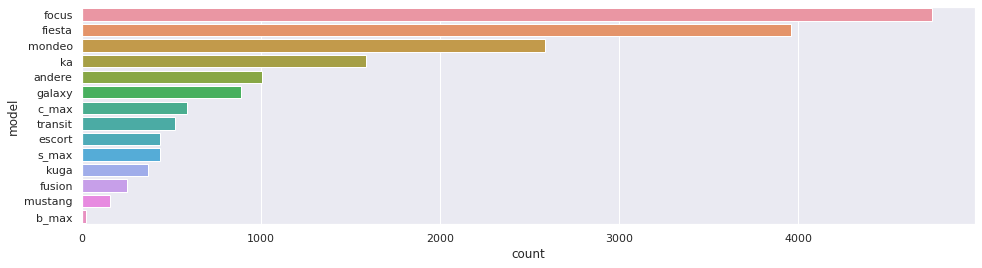

In [31]:
plt.figure(figsize=(16,4))
sns.countplot(y=df_ford['model'], order=df_ford['model'].value_counts().index)
plt.show()

In [32]:
filt = (df_ford['model'].isna())
print(f'Model information missing for {len(df_ford.loc[filt])} cars.')

Model information missing for 342 cars.


* Category "andere" (other) is not detailed enough and will be excluded
* Cars with missing model information will also be excluded

In [33]:

filt_model = ( (df_ford['model'].notna()) & (~df_ford['model'].str.contains('andere', na=True)) )
df_ford = df_ford.loc[filt_model]

## Price Range of Models

* Calculate the mean price of each model and order them by price
* Use it to sort the boxplot


In [34]:
sorted_index = df_ford.groupby('model')['price'].mean().sort_values(ascending=False).index

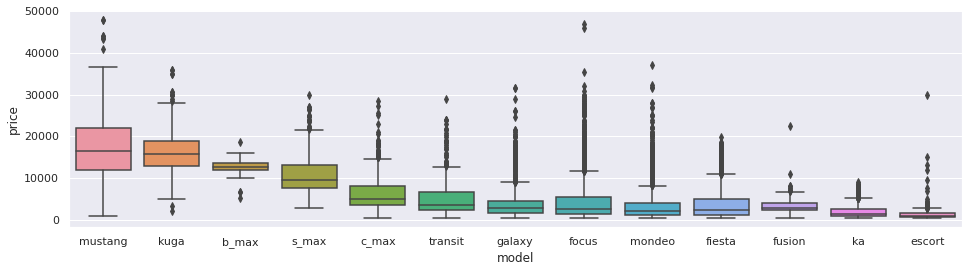

In [35]:
plt.figure(figsize=(16,4))
sns.boxplot(x='model', y='price', data=df_ford, order=sorted_index)
plt.show()

**The result seems to be realistic:**
* Mustang and Kuga are at the top of the list
* Fiesta, ka, escort at the end of the list
* If we would sort the list by the starting price, which is not included, the list would of course be slightly different

## Check Fuel type

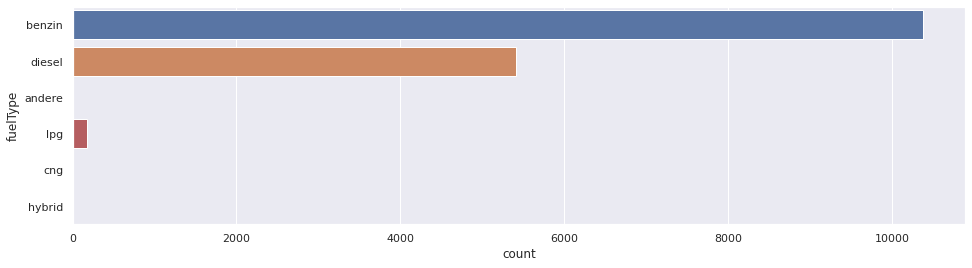

In [36]:
plt.figure(figsize=(16,4))
sns.countplot(y=df_ford['fuelType'],data=df_ford)
plt.show()

* Adjust data set, keep only benzin and diesel cars

In [37]:
df_ford = df_ford.query("fuelType=='benzin' | fuelType=='diesel' ")

## Check notRepairedDamage

* notRepairedDamage = if the car has a damage which is not repaired yet

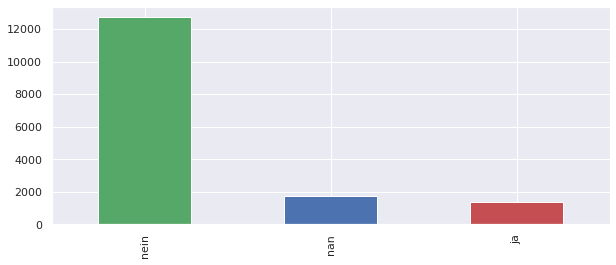

In [38]:
plt.figure(figsize=(10,4))
my_colors = ['g', 'b', 'r']
df_ford['notRepairedDamage'].value_counts(dropna=False).plot(kind='bar', color=my_colors)
plt.show()

* We will treat NaN values as cars with no damage
* To keep it simple, cars with damage will be filtered out

In [39]:
df_ford.loc[:,'notRepairedDamage'] = df_ford['notRepairedDamage'].fillna('nein')
df_ford = df_ford.query("notRepairedDamage != 'ja' ")

## Check Gearbox

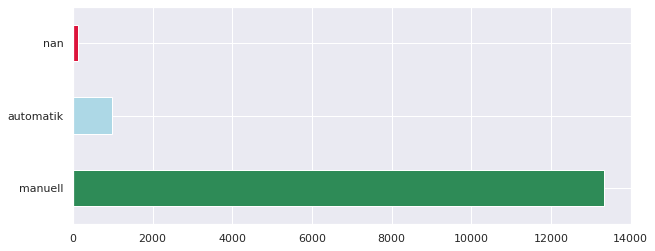

In [40]:
plt.figure(figsize=(10,4))
my_colors = ['seagreen', 'lightblue', 'crimson']
df_ford['gearbox'].value_counts(dropna=False).plot(kind='barh', color=my_colors)
plt.show()

* We could remove the NaN values, or change them to "automatik" or "manuell" with pandas
* This time we will let the pipeline (defined later) handle the NaN values from that column

# Select relevant columns

In [41]:
relevant_cols = ['model', 'vehicleType', 'gearbox', 'powerPS', 'kilometer','fuelType', 'yearOfRegistration', 'price']

In [42]:
data = df_ford.loc[:,relevant_cols]

In [43]:
data.head(3)

,model,vehicleType,gearbox,powerPS,kilometer,fuelType,yearOfRegistration,price
8,c_max,bus,manuell,125,30000,benzin,2014,14500
18,c_max,bus,manuell,136,150000,diesel,2007,7550
73,fiesta,kleinwagen,manuell,50,150000,benzin,2002,750


# Quick overview of numerical features

## Numerical features before scaling

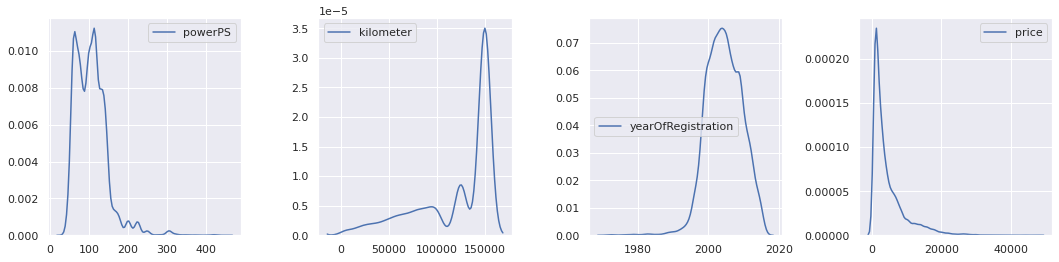

In [44]:
f = plt.figure(figsize=(18,4))
f.subplots_adjust(hspace=0.2, wspace=0.4)

f.add_subplot(1,4,1)
sns.kdeplot(data['powerPS'])

f.add_subplot(1,4,2)
sns.kdeplot(data['kilometer'])

f.add_subplot(1,4,3)
sns.kdeplot(data['yearOfRegistration'])

f.add_subplot(1,4,4)
sns.kdeplot(data['price'])
plt.show()

* We can see that some of the numerical features have big differences in terms of scale
* Plotting them in one chart without scaling the features:

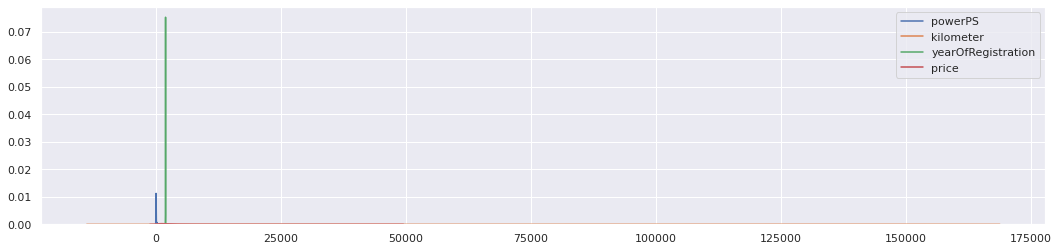

In [45]:
plt.figure(figsize=(18,4))
sns.kdeplot(data['powerPS'])
sns.kdeplot(data['kilometer'])
sns.kdeplot(data['yearOfRegistration'])
sns.kdeplot(data['price'])
plt.show()

* Now let's scale our features and check again

## Numerical features when scaled

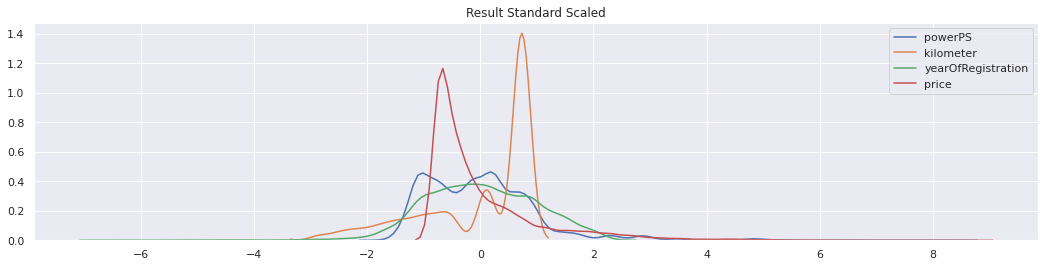

In [46]:
col_names = [cname for cname in data.columns if data[cname].dtype in ['int64', 'float64']]
scaler = StandardScaler()

#If you want to see the plot when MinMax scaled, uncomment next lines
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0,1))

df_s = scaler.fit_transform(data[col_names])
df_s = pd.DataFrame(df_s, columns=data[col_names].columns)

plt.figure(figsize=(18, 4))

plt.title('Result Standard Scaled')
sns.kdeplot(df_s['powerPS'])
sns.kdeplot(df_s['kilometer'])
sns.kdeplot(df_s['yearOfRegistration'])
sns.kdeplot(df_s['price'])
plt.show()

**Here the question was raised which algorithms require feature scaling:** 
* https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm

Explanation:
> In general, algorithms that exploit distances or similarities (e.g. in form of scalar product) between data samples, such as k-NN and SVM, are sensitive to feature transformations.
> 
> Graphical-model based classifiers, such as Fisher LDA or Naive Bayes, as well as Decision trees and Tree-based ensemble methods (RF, XGB) are invariant to feature scaling, but still it might be a good idea to rescale/standartize your data.

* Although we are now able to make the graphs clearly visible in the chart above, it will not affect the XGB Model

## Correlations

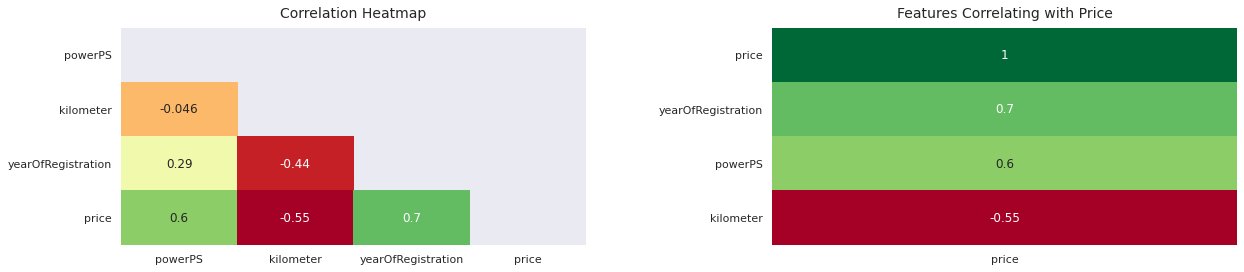

In [47]:
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))

f = plt.figure(figsize=(20, 4))
f.subplots_adjust(hspace=0.2, wspace=0.4)

f.add_subplot(1,2,1)
heatmap1 = sns.heatmap(data.corr(), annot=True, mask=mask,cmap='RdYlGn', cbar=False)
heatmap1.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=10)

f.add_subplot(1,2,2)
heatmap2 = sns.heatmap(data.corr()[['price']].sort_values(by='price', ascending=False), annot=True, cmap='RdYlGn', cbar=False)
heatmap2.set_title('Features Correlating with Price', fontdict={'fontsize':14}, pad=10)
plt.show()

**Check the correlation coeffiecents in the figure on the right (Features correlating with Price):**
* We can see that the **year of registration** has a strong positive relationship, which means that if the year increases (newer car), the price of the car will also increase - that sounds reasonable
* **powerPs** behaves similar (perhaps a more moderate positive relationship), but the more ps the car has, the higher the price - also seams reasonable
* Why does it make sense that **kilometer** has a moderate to strong negative relationship? The higher the kilometer, the lower the price. So cars that have less kilometers are more expensive - seems to be correct as well

# Model Development

## Train Test Split

In [48]:
X = data.drop('price', axis=1)
y = data['price']

* Store column names based on their data type to perform preprocessing steps based on them

In [49]:
categorical_cols_OHE = [cname for cname in X.columns if X[cname].dtype =='object']

In [50]:
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

## Define Preprocessing Steps

* Altough we don't need to impute and scale numerical data (XGB invariant to feature scaling) in this case, I included the steps in the pipeline for anyone who maybe wants to use the workbook for checking different brands (other than Ford) or uses a different model.
* You can also uncomment the line in the next cell and use the StandardScaler or MinMaxScaler/RobustScaler (don't forget to import them before) and check the results
* All categorical columns are one hot encoded, because each column does not contain too many unique values (might need to be changed if you analyze a different brand or multiple brands)

In [52]:
num_transformer = Pipeline(steps=[
    ('imput_num', SimpleImputer(strategy='mean')),
    #('stand_scaler', StandardScaler())
])

In [53]:
cat_ohe_transformer = Pipeline(steps=[
    ('impute_cat', SimpleImputer(strategy='most_frequent')),
    ('OHE', OneHotEncoder(handle_unknown='ignore'))
])

In [54]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numerical_cols),
    ('cat_ohe', cat_ohe_transformer, categorical_cols_OHE)
])

## Define Model

In [55]:
from xgboost import XGBRegressor

In [56]:
xgb_regr = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=0, n_jobs=4)

## Define Pipeline

In [57]:
pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', xgb_regr)
])

## Fit Pipeline

In [58]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imput_num',
                                                                   SimpleImputer())]),
                                                  ['powerPS', 'kilometer',
                                                   'yearOfRegistration']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OHE',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['model', 'vehicleType',
                                                   'gearbox', 'fuelType'])])),
            

## Make Predictions

In [59]:
y_pred = pipe.predict(X_valid)

## Evaluate Model

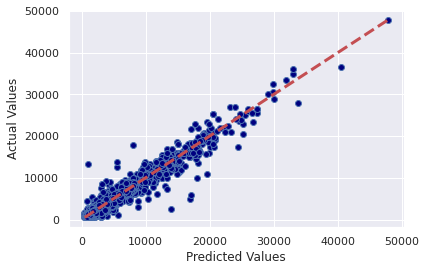

In [60]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_valid, edgecolors=('b'), color='navy')
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=3)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
plt.show()

In [61]:
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

In [62]:
print('Performance:')
print('-'*30)
print(f'Mean Absolute Error: {round(mae, 2)}')
print(f'Mean Squared Error: {round(mse, 2)}')
print(f'Root Mean Squared Error: {round(rmse, 2)}')
print(f'R2 Score: {round(r2,2)}')

Performance:
------------------------------
Mean Absolute Error: 680.63
Mean Squared Error: 1296394.66
Root Mean Squared Error: 1138.59
R2 Score: 0.94
